In [280]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import math
from arch import arch_model

In [281]:
def parser(s):
    return datetime.strptime(s, '%d-%m-%Y')

In [282]:
#read data
data = pd.read_csv('TSLA.csv', parse_dates=[0], index_col=0, date_parser=parser)

In [283]:
#infer the frequency of the data
data = data.asfreq(pd.infer_freq(data.index))
# Remove rows with NaN values
data = data.dropna()
print(data.head())
print(data.tail())


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-23  135.869995  145.380005  134.270004  143.750000  143.750000   
2023-01-24  143.000000  146.500000  141.100006  143.889999  143.889999   
2023-01-25  141.910004  146.410004  138.070007  144.429993  144.429993   
2023-01-26  159.970001  161.419998  154.759995  160.270004  160.270004   
2023-01-27  162.429993  180.679993  161.169998  177.899994  177.899994   

                 Volume  
Date                     
2023-01-23  203119200.0  
2023-01-24  158699100.0  
2023-01-25  192734300.0  
2023-01-26  234815100.0  
2023-01-27  306590600.0  
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-01-12  220.080002  225.339996  217.149994  218.889999  218.889999   
2024-01-16  215.100006  223.490005  212.179993  219.910004  219.910004   
202

In [284]:
start_date = datetime(2023,1,23)
end_date = datetime(2023,11,23)
data_train = data[start_date:end_date]

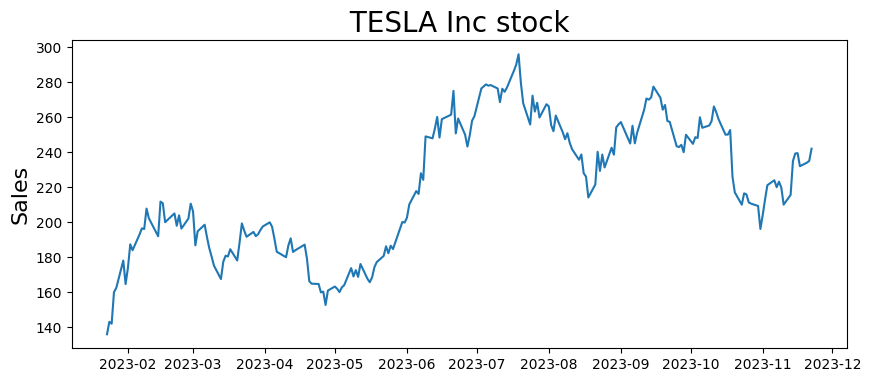

In [285]:
plt.figure(figsize=(10,4))
plt.plot(data_train.index, data_train['Open'])
plt.title(' TESLA Inc stock ', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Making the data stationary


In [286]:
first_diff = data_train.diff()[1:]
first_diff.head()
first_diff.iloc[0] = 0
first_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2023-01-25,-1.089996,-0.089996,-3.029999,0.539994,0.539994,34035200.0
2023-01-26,18.059997,15.009994,16.689988,15.840011,15.840011,42080800.0
2023-01-27,2.459992,19.259995,6.410003,17.629990,17.629990,71775500.0
2023-01-30,15.620010,-0.909989,5.330002,-11.239990,-11.239990,-75711800.0
...,...,...,...,...,...,...
2023-11-16,0.200012,-5.819992,-5.489990,-9.250000,-9.250000,-13537200.0
2023-11-17,-7.490005,-3.490006,-4.420014,0.710007,0.710007,5716000.0
2023-11-20,2.039993,-0.289993,4.480011,1.300003,1.300003,-26212700.0


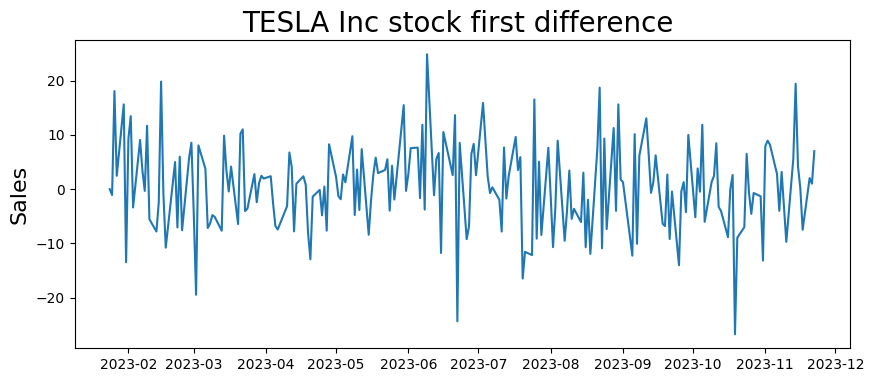

In [287]:
plt.figure(figsize=(10,4))
plt.plot(first_diff.index, first_diff['Open'])
plt.title('TESLA Inc stock first difference ', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [288]:
result = adfuller(first_diff['Open'])

# Extract and print the test statistics and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Compare the test statistic with critical values to make a decision
if result[1] <= 0.05:
    print("Reject the null hypothesis. The time series is stationary.")
else:
    print("Fail to reject the null hypothesis. The time series is non-stationary.")

ADF Statistic: -16.586339529271108
p-value: 1.815301707141911e-29
Reject the null hypothesis. The time series is stationary.


## The data is stationary, so we can move with the modelling


## ACF

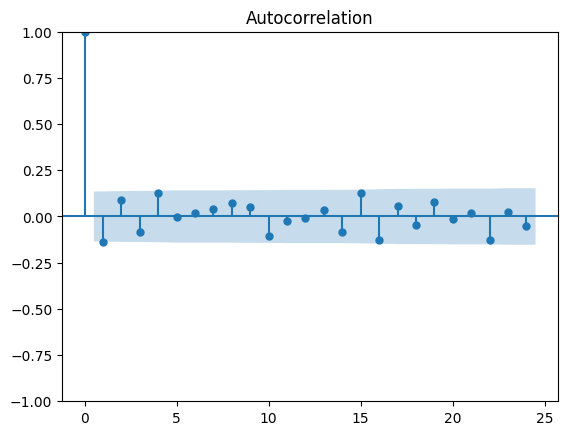

In [289]:
open=first_diff['Open']
plot_acf(open)
plt.show()

## Only lag 1 seems to be significant, so taking MA(1)

## PACF

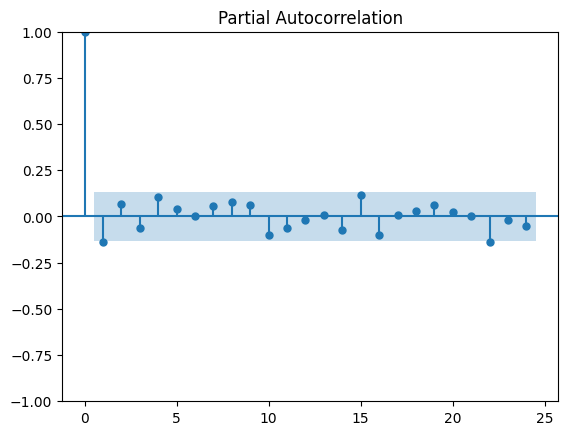

In [290]:
plot_pacf(open)
plt.show()

## Again only lag 1 seems to be significant, so taking AR(1)


In [291]:
#defining testing data
train_end = datetime(2023,11,23)
test_end = datetime(2024,1,19)

train_data =  data[:train_end]
test_data = data[train_end + timedelta(days=1):test_end]

In [292]:
endog_column_name = 'Open'
endog = train_data[endog_column_name]
testseries = test_data[endog_column_name]

In [293]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


stepwise_fit = auto_arima(data['Open'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -859.986
Date:                Wed, 24 Jan 2024   AIC                           1725.973
Time:                        12:53:10   BIC                           1736.525
Sample:                             0   HQIC                          1730.220
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7291      0.196     -3.717      0.000      -1.114      -0.345
ma.L1          0.6137      0.230      2.672      0.008       0.164       1.064
sigma2        58.5258      4.617     12.676      0.000      49.477      67.575
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.59
Prob(Q):                              0.89   Prob(JB):                         0.17
Heteroskedasticity (H):               0.93   Skew:                            -0.02
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Thus as predicted using pacf, acf arima(1,1,1) shd be used

In [294]:
model=ARIMA(endog,order=(1,1,1))
model=model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  212
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -737.091
Date:                Wed, 24 Jan 2024   AIC                           1480.182
Time:                        12:53:10   BIC                           1490.238
Sample:                             0   HQIC                          1484.247
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7332      0.202     -3.638      0.000      -1.128      -0.338
ma.L1          0.6087      0.238      2.559      0.010       0.143       1.075
sigma2        63.3396      5.536     11.441      0.000      52.489      74.190
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.41
Prob(Q):                              0.95   Prob(JB):                         0.30
Heteroskedasticity (H):               1.16   Skew:                            -0.07
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fitting on training data-

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  212
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -737.091
Date:                Wed, 24 Jan 2024   AIC                           1480.182
Time:                        12:53:10   BIC                           1490.238
Sample:                             0   HQIC                          1484.247
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7332      0.202     -3.638      0.000      -1.128      -0.338
ma.L1          0.6087      0.238      2.559      0.010       0.143       1.075
sigma2        63.3396      5.536     11.441      0.0

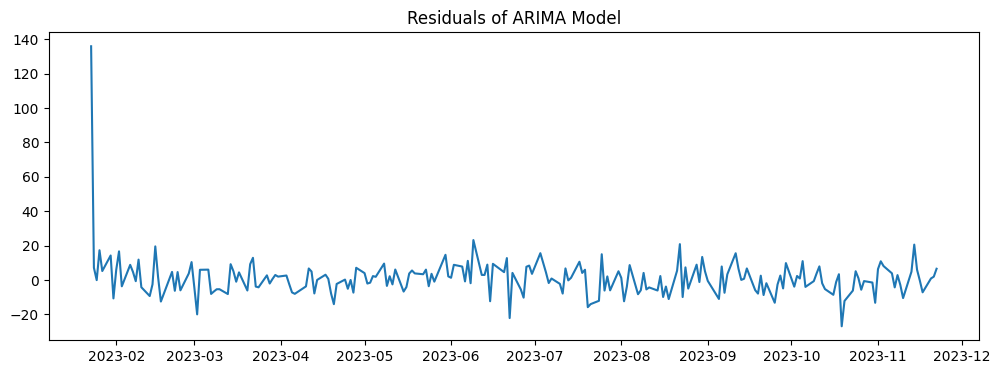

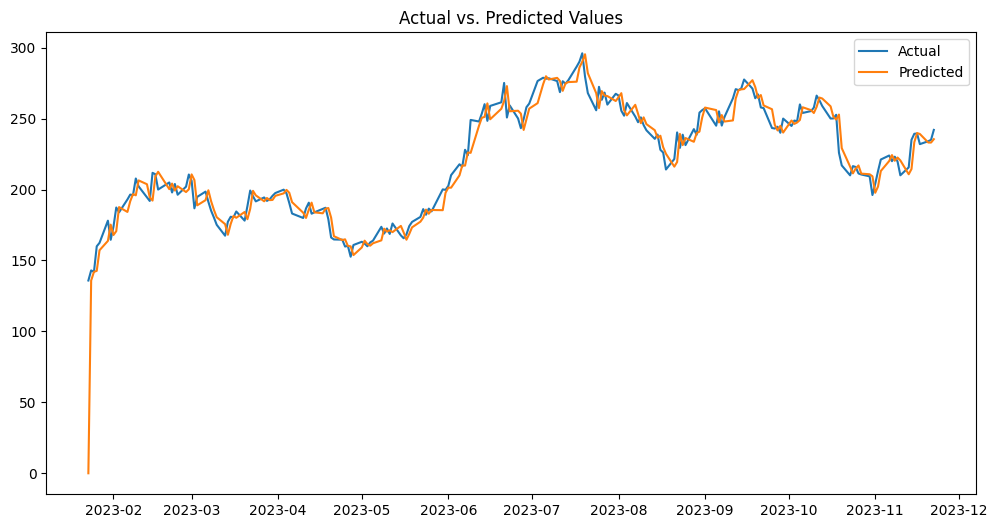

In [295]:
# Fit ARIMA model
order = (1, 1, 1)  # Replace with the order you want (p, d, q)
model = sm.tsa.ARIMA(endog, order=order)
results = model.fit()

# Print model summary
print(results.summary())

# Plot the residuals
residuals = results.resid
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

# Plot the actual vs. predicted values
predictions = results.predict(start=endog.index[0], end=endog.index[-1])
plt.figure(figsize=(12, 6))
plt.plot(endog, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

## Direct prediction for the test data

mse = 164.37658834139435, rmse = 12.820943348341975


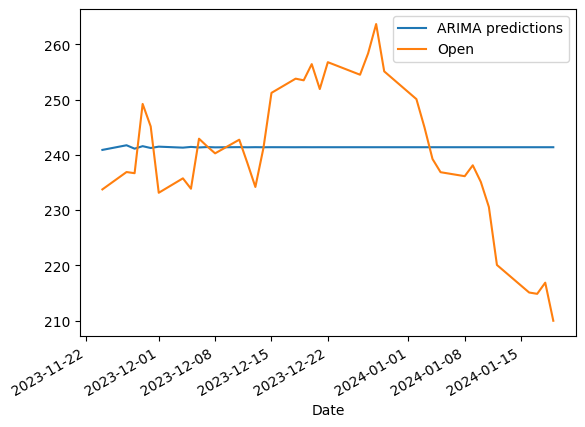

In [296]:
start=len(endog)
end=len(data['Open'])-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2023-11-24',end='2024-1-19')

pred=results.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')


pred = pd.Series(pred)
pred_df = pred.to_frame()
pred_df.set_index(test_data.index, inplace=True)  # Set the new column as the index


#pred.index=index_future_dates
pred_df.plot(legend=True)
testseries.plot(legend=True)

mse = mean_squared_error(testseries, pred_df)
rmse = np.sqrt(mse)
print(f"mse = {mse}, rmse = {rmse}")

## Using Rolling forecasts

mse = 31.88392462931076, rmse = 5.646585218458211


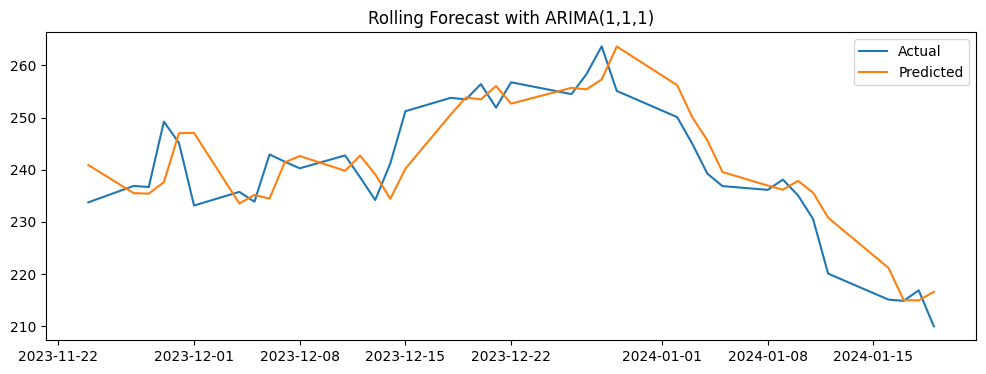

In [297]:
forecasts = []
actual_values = []
train_size = len(train_data['Open'])

for i in range(train_size, len(data['Open'])):
    # Train the ARIMA(1,1,1) model on the current training set
    model = ARIMA(data['Open'][:i], order=(1,1,1))
    results = model.fit()

    # Make a one-step forecast
    forecast = results.forecast(steps=1)

    # Append the forecast and actual value to the lists
    forecasts.append(forecast.values)
    actual_values.append(data['Open'][i])

# Plot the actual vs predicted values
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(test_data.index, actual_values, label='Actual')
plt.plot(test_data.index, forecasts, label='Predicted')
plt.legend()

mse = mean_squared_error(actual_values, forecasts)
rmse = np.sqrt(mse)
print(f"mse = {mse}, rmse = {rmse}")

plt.title('Rolling Forecast with ARIMA(1,1,1)')
plt.show()

## Now consider the Errors


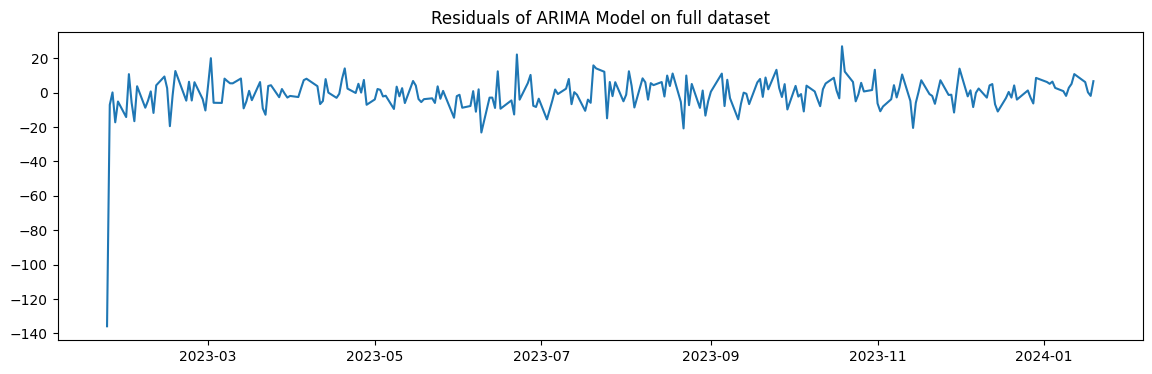

In [298]:
predlist = []
for i in predictions.values:
    predlist.append(float(i))

predpd = pd.Series(predlist, index = train_data.index)

forelist = []
for i in forecasts:
    forelist.append(float(i))

pd_forecasts = pd.Series(forelist, index=test_data.index)

comp_pred = pd.concat([predpd, pd_forecasts])

errors = comp_pred - data['Open']
plt.figure(figsize=(14, 4))
plt.plot(errors)
plt.title('Residuals of ARIMA Model on full dataset')
plt.show()
train_err = errors[:train_end]
test_err = errors[train_end:]




# Implementing GARCH on errors

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1642.1971360722987
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1234.2848712474288
Iteration:      3,   Func. Count:     19,   Neg. LLF: 754.9683863417131
Iteration:      4,   Func. Count:     24,   Neg. LLF: 752.9612372985814
Iteration:      5,   Func. Count:     29,   Neg. LLF: 752.2745041227035
Iteration:      6,   Func. Count:     34,   Neg. LLF: 752.2265555612839
Iteration:      7,   Func. Count:     39,   Neg. LLF: 752.225461704619
Iteration:      8,   Func. Count:     44,   Neg. LLF: 752.2246281478651
Iteration:      9,   Func. Count:     49,   Neg. LLF: 752.2215558433519
Iteration:     10,   Func. Count:     54,   Neg. LLF: 752.220507426522
Iteration:     11,   Func. Count:     59,   Neg. LLF: 752.2202713848769
Iteration:     12,   Func. Count:     64,   Neg. LLF: 752.2202559784728
Iteration:     13,   Func. Count:     68,   Neg. LLF: 752.220255978787
Optimization terminated successfully    (Exit mode 0)
           

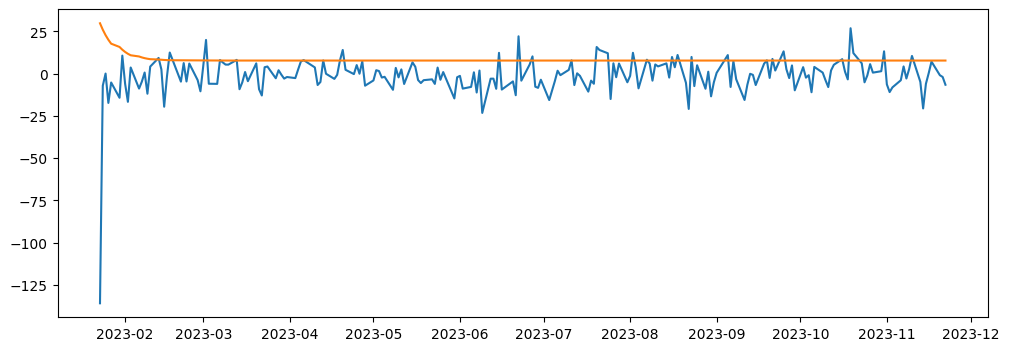

In [299]:
# Implemeting garch model
import arch
garch_model = arch.arch_model(train_err, vol='Garch', p=1, q=1)  # Adjust p and q as needed
garch_results = garch_model.fit()
print(garch_results.summary())

plt.figure(figsize=(12, 4))
plt.plot(train_data.index, train_err, label='Actual')
plt.plot(train_data.index, garch_results.conditional_volatility, label='GARCH conditional volatility')

# GARCH model failed, bad p values

______________________________________________________________________________________________________________________________________________________________________________________

# Fitting ARIMA model

In [300]:
# getting order for arima
import warnings
warnings.filterwarnings("ignore")


stepwise_fit = auto_arima(errors, 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                        SARIMAX   Log Likelihood                -965.237
Date:                Wed, 24 Jan 2024   AIC                           1932.474
Time:                        12:53:16   BIC                           1935.996
Sample:                             0   HQIC                          1933.892
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       132.1609      1.896     69.707      0.000     128.445     135.877
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):             59804.64
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -6.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        77.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                               SARIMAX Results                                
Dep. Variable:                   None   No. Observations:                  212
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -835.306
Date:                Wed, 24 Jan 2024   AIC                           1676.612
Time:                        12:53:16   BIC                           1686.667
Sample:                             0   HQIC                          1680.676
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6597      0.027    -24.657      0.000      -0.712      -0.607
ar.L2         -0.4223      0.025    -16.940      0.000      -0.471      -0.373
sigma2       160.2579      5.728     27.976      0.0

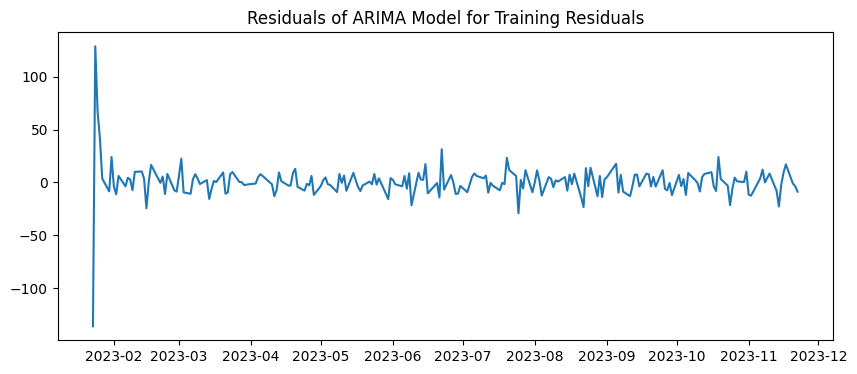

In [301]:
# Fit ARIMA model on training residuals
# Replace the first index value of residuals with zero
residuals.iloc[0] = 0  # Assuming residuals_residuals is a pandas Series
residuals_order = (2, 1, 0)  # Replace with the order you want (p, d, q) for residuals
residuals_model = sm.tsa.ARIMA(train_err, order=residuals_order)
residuals_results = residuals_model.fit()

# Print model summary for residuals
print(residuals_results.summary())

# Plot the residuals of the residuals model
residuals_residuals = residuals_results.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals_residuals)
plt.title('Residuals of ARIMA Model for Training Residuals')
plt.show()

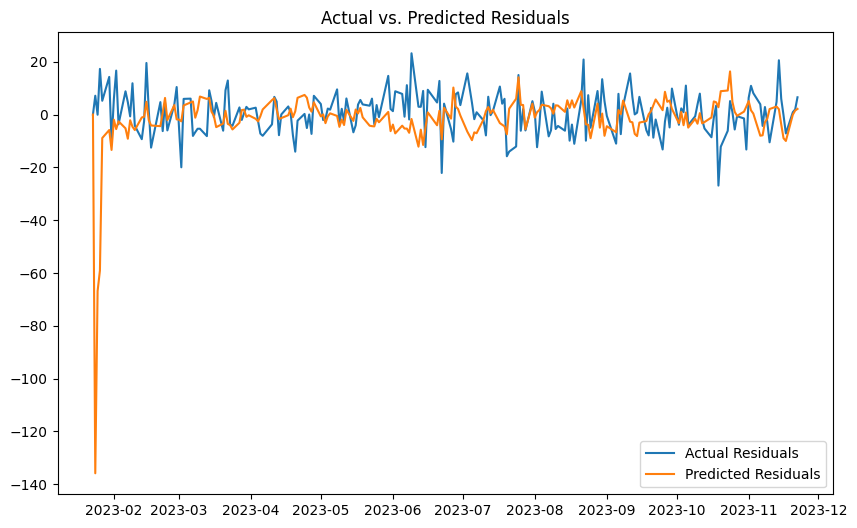

In [302]:
# Plot the actual vs. predicted values for residuals
residuals_predictions = residuals_results.predict(start=residuals.index[0], end=residuals.index[-1])
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Actual Residuals')
plt.plot(residuals_predictions, label='Predicted Residuals')
plt.title('Actual vs. Predicted Residuals')
plt.legend()
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------

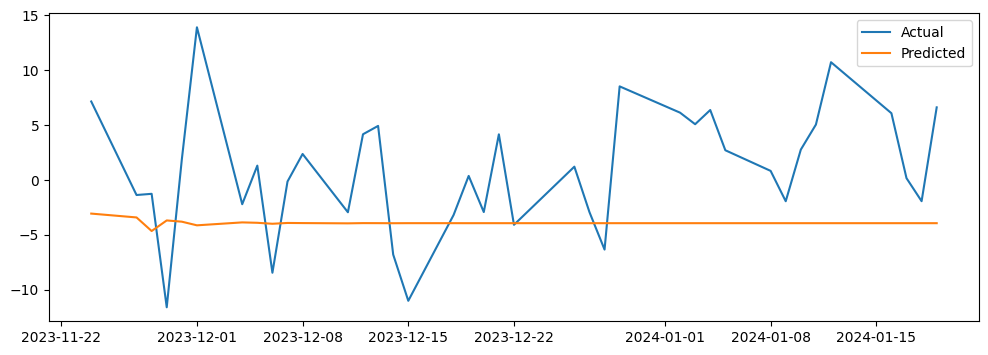

In [303]:
pred_err=residuals_results.predict(start=start, end=end,typ='levels').rename('ARIMA predictions')

pred_err = pd.Series(pred_err)
pred_df_err = pred_err.to_frame()
pred_df_err.set_index(test_err.index, inplace=True)  # Set the new column as the index

#pred.index=index_future_dates
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(test_data.index, test_err, label='Actual')
plt.plot(test_data.index, pred_df_err, label='Predicted')
plt.legend()

# mse = mean_squared_error(train_err, pred_df_err)
# rmse = np.sqrt(mse)
# print(f"mse = {mse}, rmse = {rmse}")

# Rolling forecast

mse = 45.06182346767812, rmse = 6.712810400099061


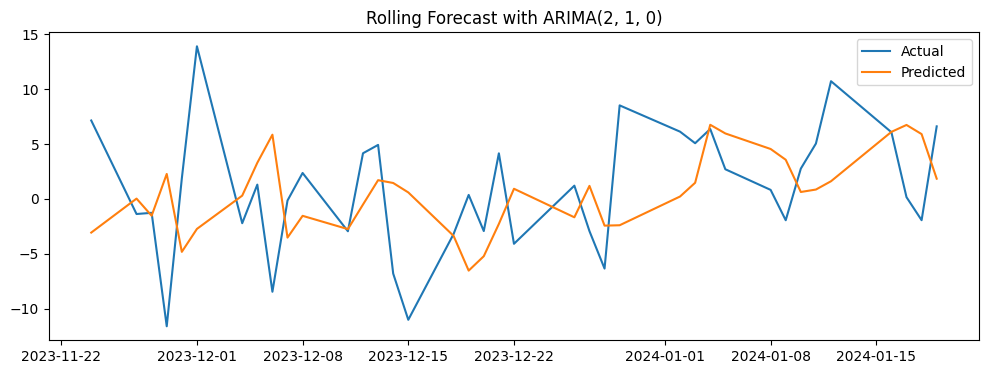

In [304]:
foreerrors = []
actual_err = []

for i in range(train_size, len(errors)):
    # Train the ARIMA(1,1,1) model on the current training set
    model = ARIMA(errors[:i], order=(2,1,0))
    results = model.fit()

    # Make a one-step forecast
    forecast_err = results.forecast(steps=1)

    # Append the forecast and actual value to the lists
    foreerrors.append(forecast_err.values)
    actual_err.append(errors[i])

# Plot the actual vs predicted values
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(test_data.index, actual_err, label='Actual')
plt.plot(test_data.index, foreerrors, label='Predicted')
plt.legend()

mse = mean_squared_error(actual_err, foreerrors)
rmse = np.sqrt(mse)
print(f"mse = {mse}, rmse = {rmse}")

plt.title('Rolling Forecast with ARIMA(2, 1, 0)')
plt.show()

# Final training fit

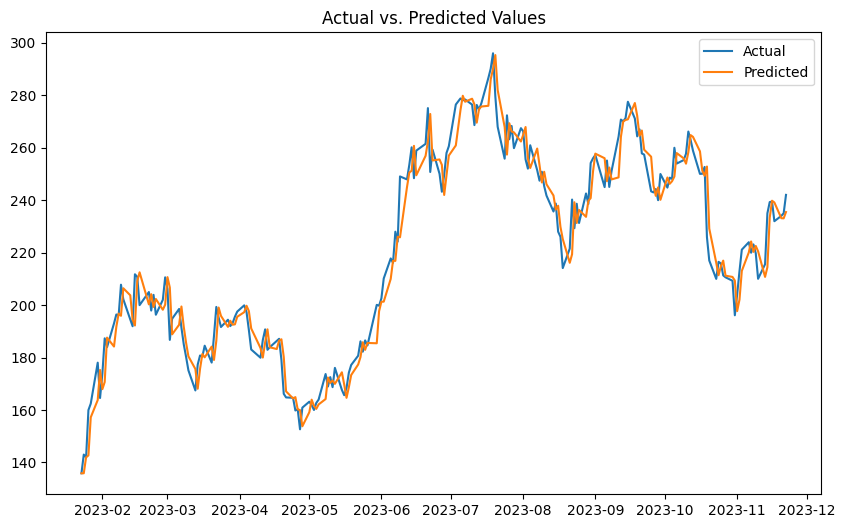

In [305]:
predictions.iloc[0] = endog.iloc[0]

# Combine the predicted residuals with the predicted 'Open' values
final_predictions = predictions + residuals_predictions


# Plot the final predicted 'Open' values
# plt.figure(figsize=(10, 6))
# plt.plot(endog, label='Actual')
# plt.plot(final_predictions, label='Final Predicted Open')
# plt.title('Final Predicted Open Values')
# # plt.legend()
# plt.show()

plt.figure(figsize=(10, 6))
plt.plot(endog, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Final Testing fit

mse = 43.21030002936305, rmse = 6.573454193144046


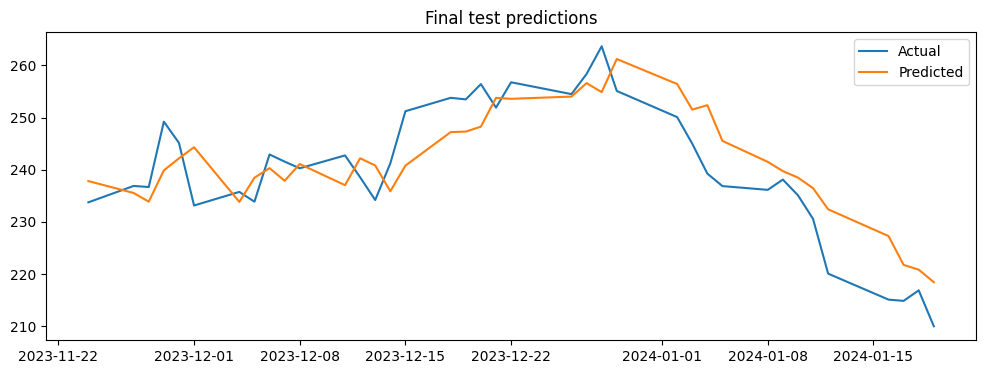

In [306]:
final_fore = [x + y for x, y in zip(forecasts, foreerrors)]
len(final_fore)

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(test_data.index, actual_values, label='Actual')
plt.plot(test_data.index, final_fore, label='Predicted')
plt.legend()

mse = mean_squared_error(actual_values, final_fore)
rmse = np.sqrt(mse)
print(f"mse = {mse}, rmse = {rmse}")

plt.title('Final test predictions')
plt.show()